# Optional Extra Credit Project (200 points)
In this project you should use thetraining data generated below to build a classifier based on a decison trees algorithm. **You cannot use the available libraries like Scikit Learn**. Please make sure that your code 



1.   classifies the given training data based on the decsion tree we discussed in the class. You should use the entropy  loss function.
2.    uses bagging to reduce the variance of the classifier.
1.   plots the desion regions
2.  plots the training data and the decision boundaries on a single plot

**To get the credit for this HW your code needs to be functional and clear.** 


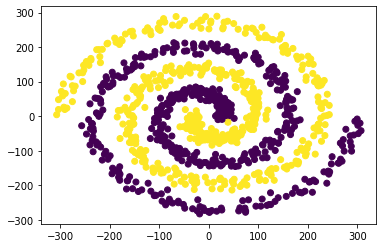

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gen_spiral(N, NS, sigma):
  theta = np.linspace(0, NS*2*np.pi, int(N/2))
  r = np.linspace(30, 300, int(N/2))
  X = np.array([r*np.cos(theta)+ sigma* np.random.normal(0,1, int(N/2)), 
                r*np.sin(theta)+ sigma* np.random.normal(0,1, int(N/2) )])
  Y = np.zeros(int(N/2), dtype ='int16')
  
  temp = np.array([-r*np.cos(theta)+ sigma* np.random.normal(0,1, int(N/2)), 
                -r*np.sin(theta)+ sigma* np.random.normal(0,1, int(N/2) )+3]) 

  X = np.hstack((X, temp))
  Y = np.append(Y, np.ones(int(N/2), dtype ='int16'))
  index =np.arange(len(Y))
  np.random.shuffle(index)
  X = X[:,index]
  Y = Y[index]
  plt.scatter(X[0,:], X[1,:], c = Y)
  
  return X, Y

X, Y = gen_spiral(1000, 2, 10)

**Ric wrote:** The first step is to explore the data.

In [3]:
X.shape

(2, 1000)

In [4]:
X.ndim

2

In [5]:
print(np.min(X[0,:]), np.min(X[1,:]))
print(np.max(X[0,:]), np.max(X[1,:]))

-307.21016377298884 -283.05713708042686
307.40084261263905 289.1767555960177


In [6]:
print(np.max(X[0,:]), np.max(X[1,:]))

307.40084261263905 289.1767555960177


In [7]:
Y.shape

(1000,)

In [8]:
Y.ndim

1

In [9]:
set(Y)

{0, 1}

In [10]:
np. count_nonzero(Y == 0)

500

In [11]:
np. count_nonzero(Y == 1)

500

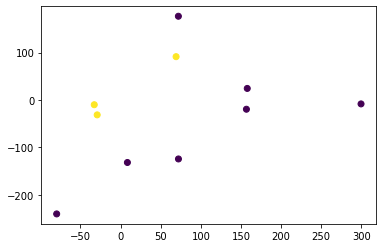

In [12]:
plt.scatter(X[0,:10], X[1,:10], c = Y[:10])

In order to keep track of labels, we will stack the labels with the X matrix

In [13]:
spiralData = np.vstack((X,Y))
spiralData

array([[  69.18655953,  -29.10832432,   72.04414889, ...,  -47.28580408,
          88.96890204,   99.7213287 ],
       [  91.29694701,  -31.4551558 ,  176.53137151, ...,   71.79188724,
        -112.17129131,  170.77448178],
       [   1.        ,    1.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

**Ric wrote:** Next I wil try to find the best way to sort. My guess is that I need two sorting methods: one for when I am searching in the x axis and another for when I am searching in the y axis.

In [14]:
def sort_xAxisVals(matrix):
    """Assumes a 2x1000 array in R^2, a numpy array.
    returns a vector of sorted values of x-axis values"""
    sortedVals = np.sort(matrix[0,:])
    return sortedVals

In [15]:
def sort_yAxisVals(matrix):
    """Assumes a 2x1000 array in R^2, a numpy array.
    returns a vector of sorted values of y-axis values"""
    sortedVals = np.sort(matrix[1,:])
    return sortedVals

**Ric wrote:** Now I will develop a method to create the datasets D_L and D_R in the leaves.

In [16]:
def createLeaves2(Matrix,threshold,axis):
    """Assumes a 3-d matrix and, a numpy array;
    a threshold value, a float
    and an axis value, axis=0 implies x-axis and axis=1 implies y-axis.
    Returns two matrices, a numpy array.
    One is matrix includes the subset of observations less or equal than the threshold,
    The second matrix includes the subset of observations greater than the threshold."""
    
    D_left = np.array([np.nan,np.nan,np.nan]).reshape(3,1)
    D_right = np.array([np.nan,np.nan,np.nan]).reshape(3,1)

    if axis not in (0,1):
        raise ValueError('Type 0 to search in x-axis or type 1 to search in y-axis')
 
    elif axis == 0:
        #print('0 branch')
        for i in range(len(Matrix[0,:])):
            if Matrix[:,i][0] <= threshold:
                currObservation = Matrix[:,i].reshape(3,1)
                D_left = np.hstack((D_left,currObservation))
            elif Matrix[:,i][0] > threshold:
                currObservation = Matrix[:,i].reshape(3,1)
                D_right = np.hstack((D_right,currObservation))
            else:
                pass
                #print("Threshold exception in observation {}".format(i))
        
        if np.isnan(D_left).all():
            return D_left,D_right[:,1:]
        elif np.isnan(D_right).all():
            return D_left[:,1:],D_right
        else:
            return D_left[:,1:],D_right[:,1:]

    elif axis == 1:
        #print('1 branch')
        for i in range(len(Matrix[1,:])):
            if Matrix[:,i][1] <= threshold:
                currObservation = Matrix[:,i].reshape(3,1)
                D_left = np.hstack((D_left,currObservation))
            elif Matrix[:,i][1] > threshold:
                currObservation = Matrix[:,i].reshape(3,1)
                D_right = np.hstack((D_right,currObservation))
            else:
                pass
                #print("Threshold exception in observation {}".format(i))
        
        if np.isnan(D_left).all():
            return D_left,D_right[:,1:]
        elif np.isnan(D_right).all():
            return D_left[:,1:],D_right
        else:
            return D_left[:,1:],D_right[:,1:]

**Ric wrote:** The other piece I need is a function to calculate the entropy of the data in a node.

In [17]:
def entropyWithinNode(Matrix):
    """Assumes a 3-d matrix and, a numpy array;
    returns the entropy loss function value for that array"""
    nodeSize = len(Matrix[0,:])
    mask_label0 = (Matrix[2,:] == 0)
    mask_label1 = (Matrix[2,:] == 1)
    obs_label0 = Matrix[:,mask_label0]
    obs_label1 = Matrix[:,mask_label1]
    len_label0 = len(obs_label0[0,:]) 
    len_label1 = len(obs_label1[0,:])
    p_label0 = len_label0/nodeSize 
    p_label1 = len_label1/nodeSize
    if (p_label0==0) or (p_label1==0):
        raise ValueError('Log of 0 is -inf')
    else:
        H_node = -1*(p_label0*np.log2(p_label0)+p_label1*np.log2(p_label1))
        return H_node

In [18]:
entropyWithinNode(spiralData)

1.0

**Ric wrote:** Testing the within node entropy loss function I obtained the result equal to 1. Given that there are 50% of 0 labels and 50% of 1 labels this result goes as expected for the entropy curve shown in class.

**Ric wrote:** The next piece would be to build a function that seraches the node partition with the lowest entropy.

In [19]:
def splitWithLowEntropy(Matrix,axis):
    """Assumes a 3-d matrix and, a numpy array;
    and an axis value, axis=0 implies x-axis and axis=1 implies y-axis.
    Returns a threshold, a float; 
    the entropy loss function value for the best partition, a float;
    and the combination of two matrices with lowest entropy, a numpy array.
    One is matrix includes the subset of observations less or equal than the threshold,
    The second matrix includes the subset of observations greater than the threshold."""
    
    entropies = {}
    lenRoot = len(Matrix[0,:])

    if axis == 0:
        #print('axis 0 branch')
        xSearchSpace = sort_xAxisVals(Matrix)
        for i in range(len(xSearchSpace)):
            #print(i)
            currThreshold = xSearchSpace[i]
            D_left, D_right = createLeaves2(Matrix,currThreshold,axis)
            if np.isnan(D_left).all():
                #print('if branch')
                rightNodeSize = len(D_right[0,:])
                p_right = rightNodeSize/lenRoot
                try:
                    currH_Tree = p_right*entropyWithinNode(D_right)
                    entropies[currThreshold] = currH_Tree
                except:
                    pass
            elif np.isnan(D_right).all():
                #print('elif branch')
                leftNodeSize = len(D_left[0,:])
                p_left = leftNodeSize/lenRoot
                try:
                    currH_Tree = p_left*entropyWithinNode(D_left)
                    entropies[currThreshold] = currH_Tree
                except:
                    pass
            else: 
                #print('else branch')
                leftNodeSize = len(D_left[0,:])
                rightNodeSize = len(D_right[0,:])
                p_left = leftNodeSize/lenRoot
                p_right = rightNodeSize/lenRoot
                try:
                    currH_Tree = p_left*entropyWithinNode(D_left) + p_right*entropyWithinNode(D_right)
                    entropies[currThreshold] = currH_Tree
                except:
                    pass

    elif axis == 1:
        #print('axis 1 branch')
        ySearchSpace = sort_yAxisVals(Matrix)
        for i in range(len(ySearchSpace)):
            #print(i)
            currThreshold = ySearchSpace[i]
            D_left, D_right = createLeaves2(Matrix,currThreshold,axis)
            if np.isnan(D_left).all():
                rightNodeSize = len(D_right[1,:])
                p_right = rightNodeSize/lenRoot
                try:
                    currH_Tree = p_right*entropyWithinNode(D_right)
                    entropies[currThreshold] = currH_Tree
                except:
                    pass
            elif np.isnan(D_right).all():
                leftNodeSize = len(D_left[1,:])
                p_left = leftNodeSize/lenRoot
                try:
                    currH_Tree = p_left*entropyWithinNode(D_left)
                    entropies[currThreshold] = currH_Tree
                except:
                    pass
            else: 
                leftNodeSize = len(D_left[1,:])
                rightNodeSize = len(D_right[1,:])
                p_left = leftNodeSize/lenRoot
                p_right = rightNodeSize/lenRoot
                try:
                     currH_Tree = p_left*entropyWithinNode(D_left) + p_right*entropyWithinNode(D_right)
                     entropies[currThreshold] = currH_Tree
                except:
                    pass

    bestThreashold = min(entropies, key=entropies.get)
    best_D_left, best_D_right = createLeaves2(Matrix,bestThreashold,axis)
    minEntropy = entropies.get(bestThreashold)

    return bestThreashold, minEntropy, best_D_left, best_D_right

**Ric wrote:** Now I am going to test the function on each axis and draw the found threshold against the data.

In [20]:
thresh, entrpy, leftLeaf, rightLeaf = splitWithLowEntropy(spiralData,0)

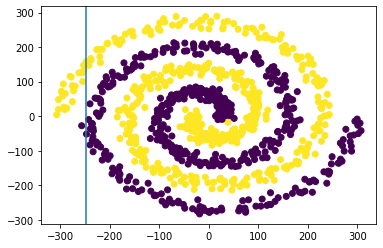

In [21]:
plt.scatter(X[0,:], X[1,:], c = Y)
plt.axvline(thresh)

In [22]:
print(thresh,entrpy)

-247.10821862252465 0.9816394273114515


In [23]:
thresh2, entrpy2, leftLeaf2, rightLeaf2 = splitWithLowEntropy(spiralData,1)

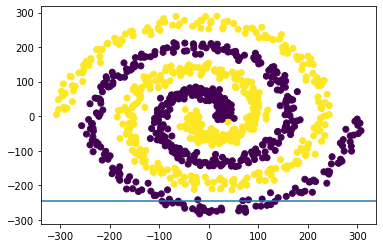

In [24]:
plt.scatter(X[0,:], X[1,:], c = Y)
plt.axhline(thresh)

In [25]:
print(thresh2,entrpy2)

211.4882824018657 0.9511212370718095


**RIc wrore:** Trying/testing a seccond branching

In [26]:
thresh1_1, entrpy1_1, left_leftLeaf, left_rightLeaf = splitWithLowEntropy(leftLeaf,1)

In [27]:
thresh1_2, entrpy1_2, right_leftLeaf, right_rightLeaf = splitWithLowEntropy(rightLeaf,1)

In [28]:
line1_x = [-350,thresh]
line1_y = [thresh1_1,thresh1_1]
line2_x = [thresh,350]
line2_y = [thresh1_2,thresh1_2]

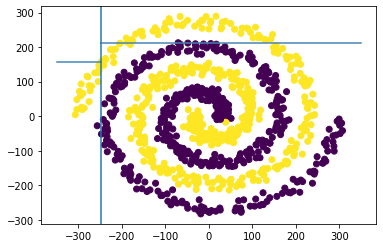

In [29]:
plt.scatter(X[0,:], X[1,:], c = Y)
plt.plot(line1_x,line1_y,'k-',c='steelblue')
plt.plot(line2_x,line2_y,'k-',c='steelblue')
plt.axvline(thresh)
plt.show()

In [30]:
print('Prior Entropy:',entrpy)
print('New Entropy:',(len(leftLeaf[0,:])/len(spiralData[0,:]))*entrpy1_1+(len(rightLeaf[0,:])/len(spiralData[0,:]))*entrpy1_2)

Prior Entropy: 0.9816394273114515
New Entropy: 0.930892432224123


**Ric wrote:** The next step is to write a function to calculate the tree entropy at a given stage/depth. 

In [31]:
def treeEntropy(leavesList,Matrix):
    """Assumes a list of leaves. Each leaf is a numpy array.
    Returns the entropy of the leaves"""
    leavesVals = []
    for i in range(len(leavesList)):
        currLeaf = leavesList[i]
        try:
            currLeafEntropy = entropyWithinNode(currLeaf)
        except:
            pass
        currLeafWeight = len(currLeaf[0,:])/len(Matrix[0,:])
        currLeafVal = currLeafWeight*currLeafEntropy
        if np.isnan(currLeafVal):
            pass
        else:
            leavesVals.append(currLeafVal)
        totalEntropy = sum(leavesVals)
    return totalEntropy

In [32]:
exampleLeaves = [left_leftLeaf,left_rightLeaf,right_leftLeaf, right_rightLeaf]

In [33]:
exampleTotEntrpy = treeEntropy(exampleLeaves,spiralData)
exampleTotEntrpy

0.9311423145169563

**Ric wrote:** Now I will try to write a function to build the whole tree. Three options to stop the growth of the tree are by specifying the  maximum depth of the tree, or by the size of the leaves, or by specifying a minimum epsilon / threshold for the total tree entropy. 

In [34]:
def spltIterator(depth):
    if depth==1:
        splitIterator = [0]
    elif (depth%2)==0:
        splitIterator = [1,0]*int((depth/2))
    else:
        splitIterator = [0] + [1,0]*int(((depth-1)/2))
    return splitIterator   

In [35]:
def nodeProbability(Matrix):
    """Assumes a 3-d matrix and, a numpy array;
    returns the probability of each class within node"""
    nodeSize = len(Matrix[0,:])
    mask_label0 = (Matrix[2,:] == 0)
    mask_label1 = (Matrix[2,:] == 1)
    obs_label0 = Matrix[:,mask_label0]
    obs_label1 = Matrix[:,mask_label1]
    len_label0 = len(obs_label0[0,:]) 
    len_label1 = len(obs_label1[0,:])
    try:
        p_label0 = len_label0/nodeSize 
    except:
        p_label0 = 0
    try:
        p_label1 = len_label1/nodeSize
    except:
        p_label1 = 0

    return [p_label0,p_label1]

In [36]:
thresholds = []
axes = []
levels = []
nodes = []
withinNodeProb = []

def growTree(Matrix,depth=2):
    """Assumes a 3-d matrix and, a numpy array;
    and the depth of the tree, an int.
    For each level/step of the tree returns:
    optimum threshold that minimizes entropy of node split, a float; 
    the axis in which the split took place. 0 for x axis and 1 for y axis;
    the level label; and int;
    the resulting nodes at the split, a list of numpy arrays;
    the within the node probabilities of each class of each resulting node;
    a list of lists...
    ... probability of class 0 at index 0 and probability of class 1 at index 1"""
    #print(thresholds)

    currAxis = depth%2
    
    try:
        thresh, entrpy, leftLeaf, rightLeaf = splitWithLowEntropy(Matrix,currAxis)
        
        thresholds.append(thresh)
        axes.append(currAxis) 
        levels.append(depth)
        nodes.append([leftLeaf,rightLeaf])
        withinNodeProb.append([nodeProbability(leftLeaf),nodeProbability(rightLeaf)])
        #print(len(thresholds))
    except:
        #print('exception')
        thresh = np.nan
        entrpy = 0 
        leftLeaf = np.array([np.nan,np.nan,np.nan]).reshape(3,1)
        rightLeaf = np.array([np.nan,np.nan,np.nan]).reshape(3,1)

        thresholds.append(thresh)
        axes.append(currAxis) 
        levels.append(depth)
        nodes.append([leftLeaf,rightLeaf])
        withinNodeProb.append([nodeProbability(leftLeaf),nodeProbability(rightLeaf)])

    if depth==1:
        #print('depth 1 reached')
        return thresholds
    else:
        #print('else branch')
        depth = depth-1
        growTree(leftLeaf,depth)
        growTree(rightLeaf,depth)
        return thresholds, axes, levels,nodes,withinNodeProb

In [37]:
t,ax,lvls,nodes,nodesProb = growTree(spiralData,3)

In [38]:
# Test to find un-checked global variable
len(nodes)

7

**Ric wrote:** I need a function to extract the leaves from the tree created by the growTree() function, so I can calculate the entropy of a tree at a given stage.

In [39]:
def getTreeLeaves(levels,nodes,nodesProb):
    """Assumes the following values from the growTree() function:
    levels, a list;
    nodes, a list of matrices;
    nodes probabilities, a list of lists with probabilities of label 0 and 
    probabilities of label 1 at each node."""
    leaves = []
    leafProb = []
    tempLeaves = []
    tempLeafProb = []

    for i in range(len(levels)):
        if levels[i] == 1:
            tempLeaves.append(nodes[i])
            tempLeafProb.append(nodesProb[i])
    
    for i in range(len(tempLeaves)):
        #print('INDEX',i)
        for j in range(len(tempLeaves[i])):
            #print('JINDEX',j)
            #print(not np.isnan(tempLeaves[i][j]).all())
            #print(tempLeaves[i][j])
            
            if not np.isnan(tempLeaves[i][j]).all():
                leaves.append(tempLeaves[i][j])
                leafProb.append(tempLeafProb[i][j])
                #print('True')

    return leaves,leafProb

In [40]:
# Extracting leaves from the growTree() example
treeLeaves, leafProb = getTreeLeaves(lvls,nodes,nodesProb)

In [41]:
# Testing tree entropy for the leaves of the growTree() example
treeEntropy(treeLeaves,spiralData)

0.8888990663290061

**Ric wrote:** I will write a compact function to find how deep I have to build a tree to minimize entropy.

In [42]:
# These variables are global variables for unknown reason. Reset before running growTree()
# I know is a problem but I have no time to correct this issue.
thresholds = []
axes = []
levels = []
nodes = []
withinNodeProb = []

def growTreeGetEntropy(Matrix,depth): 

    threshold,axiis,niveles,nodos,probNodos = growTree(Matrix,depth)
    print('Number of thresholds:',len(nodos))
    hojasArbol, probHoja = getTreeLeaves(niveles,nodos,probNodos)
    print('Number of leaves:',len(hojasArbol))
    entropia = treeEntropy(hojasArbol,Matrix)
    return entropia

In [43]:
# These variables are global variables for unknown reason. Reset before running growTree()
# I know is a problem but I have no time to correct this issue.
thresholds = []
axes = []
levels = []
nodes = []
withinNodeProb = []

exEntropy = growTreeGetEntropy(spiralData,3)
print('Tree entropy with depth=3:',exEntropy)

Number of thresholds: 7
Number of leaves: 4
Tree entropy with depth=3: 0.8888990663290061


In [44]:
# These variables are global variables for unknown reason. Reset before running growTree()
# I know is a problem but I have no time to correct this issue.
thresholds = []
axes = []
levels = []
nodes = []
withinNodeProb = []

exEntropy = growTreeGetEntropy(spiralData,10)
print('Tree entropy with depth=10:',exEntropy)

Number of thresholds: 1023
Number of leaves: 18
Tree entropy with depth=10: 0.6099382368983972


In [45]:
# These variables are global variables for unknown reason. Reset before running growTree()
# I know is a problem but I have no time to correct this issue.
thresholds = []
axes = []
levels = []
nodes = []
withinNodeProb = []

exEntropy = growTreeGetEntropy(spiralData,20)
print('Tree entropy with depth=20:',exEntropy)

Number of thresholds: 1048575
Number of leaves: 52
Tree entropy with depth=20: 0.2467316435930489


**Ric wrote:** With a depth of 20 we achieve an entropy of 0.23. Running the code with a depth of 40 makes the google colab crash.

In [46]:
line = 0
for i in range(len(levels)):
    if np.isnan(thresholds[i]):
        pass
    else:
        print('line',line,'treeLevel:',levels[i],'axisSplit:',axes[i],'index:',i,'thresholdVal:',thresholds[i],'nodeProb:',withinNodeProb[i])
        line += 1

line 0 treeLevel: 20 axisSplit: 0 index: 0 thresholdVal: -247.10821862252465 nodeProb: [[0.041666666666666664, 0.9583333333333334], [0.5112704918032787, 0.4887295081967213]]
line 1 treeLevel: 19 axisSplit: 1 index: 1 thresholdVal: 158.14425332282403 nodeProb: [[0.041666666666666664, 0.9583333333333334], [0.0, 0.0]]
line 2 treeLevel: 18 axisSplit: 0 index: 2 thresholdVal: -247.10821862252465 nodeProb: [[0.041666666666666664, 0.9583333333333334], [0.0, 0.0]]
line 3 treeLevel: 17 axisSplit: 1 index: 3 thresholdVal: 158.14425332282403 nodeProb: [[0.041666666666666664, 0.9583333333333334], [0.0, 0.0]]
line 4 treeLevel: 16 axisSplit: 0 index: 4 thresholdVal: -247.10821862252465 nodeProb: [[0.041666666666666664, 0.9583333333333334], [0.0, 0.0]]
line 5 treeLevel: 15 axisSplit: 1 index: 5 thresholdVal: 158.14425332282403 nodeProb: [[0.041666666666666664, 0.9583333333333334], [0.0, 0.0]]
line 6 treeLevel: 14 axisSplit: 0 index: 6 thresholdVal: -247.10821862252465 nodeProb: [[0.041666666666666664

In [47]:
import pandas as pd

In [48]:
treeData = pd.DataFrame(list(zip(levels,axes,thresholds,withinNodeProb)), 
                        columns =['treeLevel','axisSplit','thresholdVal','nodeProb']) 

In [49]:
treeData = treeData.dropna()

In [50]:
treeData.head(50)

,treeLevel,axisSplit,thresholdVal,nodeProb
0,20,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [..."
1,19,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [..."
2,18,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [..."
3,17,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [..."
4,16,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [..."
5,15,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [..."
6,14,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [..."
7,13,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [..."
8,12,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [..."
9,11,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [..."


In [51]:
tree_Sorted = treeData.sort_values(by='treeLevel',ascending=False).reset_index(drop=False)
tree_Sorted['leftNodeClass'] = np.nan
tree_Sorted['rightNodeClass'] = np.nan
tree_Sorted.head(50)

,index,treeLevel,axisSplit,thresholdVal,nodeProb,leftNodeClass,rightNodeClass
0,0,20,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [...",NaN,NaN
1,524288,19,1,211.488282,"[[0.5401301518438177, 0.4598698481561822], [0....",NaN,NaN
2,1,19,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [...",NaN,NaN
3,2,18,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [...",NaN,NaN
4,786432,18,0,146.650693,"[[0.018518518518518517, 0.9814814814814815], [...",NaN,NaN
5,524289,18,0,-179.293142,"[[0.8088235294117647, 0.19117647058823528], [0...",NaN,NaN
6,786433,17,1,289.176756,"[[0.018518518518518517, 0.9814814814814815], [...",NaN,NaN
7,3,17,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [...",NaN,NaN
8,524290,17,1,116.793429,"[[0.9642857142857143, 0.03571428571428571], [0...",NaN,NaN
9,655361,17,1,-213.383678,"[[0.9811320754716981, 0.018867924528301886], [...",NaN,NaN


In [52]:
for i in range(len(tree_Sorted['index'])):
    if tree_Sorted.iloc[i,4][0][0] > tree_Sorted.iloc[i,4][0][1]:
        tree_Sorted.iloc[i,5] = 0
    else:
        tree_Sorted.iloc[i,5] = 1

    if tree_Sorted.iloc[i,4][1][0] > tree_Sorted.iloc[i,4][1][1]:
        tree_Sorted.iloc[i,6] = 0
    else:
        tree_Sorted.iloc[i,6] = 1

In [53]:
tree_Sorted.head(50)

,index,treeLevel,axisSplit,thresholdVal,nodeProb,leftNodeClass,rightNodeClass
0,0,20,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [...",1.0,0.0
1,524288,19,1,211.488282,"[[0.5401301518438177, 0.4598698481561822], [0....",0.0,1.0
2,1,19,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [...",1.0,1.0
3,2,18,0,-247.108219,"[[0.041666666666666664, 0.9583333333333334], [...",1.0,1.0
4,786432,18,0,146.650693,"[[0.018518518518518517, 0.9814814814814815], [...",1.0,1.0
5,524289,18,0,-179.293142,"[[0.8088235294117647, 0.19117647058823528], [0...",0.0,0.0
6,786433,17,1,289.176756,"[[0.018518518518518517, 0.9814814814814815], [...",1.0,1.0
7,3,17,1,158.144253,"[[0.041666666666666664, 0.9583333333333334], [...",1.0,1.0
8,524290,17,1,116.793429,"[[0.9642857142857143, 0.03571428571428571], [0...",0.0,1.0
9,655361,17,1,-213.383678,"[[0.9811320754716981, 0.018867924528301886], [...",0.0,1.0


In [54]:
tree = tree_Sorted[['index','treeLevel','axisSplit','thresholdVal','leftNodeClass','rightNodeClass']]
tree.head(50)

,index,treeLevel,axisSplit,thresholdVal,leftNodeClass,rightNodeClass
0,0,20,0,-247.108219,1.0,0.0
1,524288,19,1,211.488282,0.0,1.0
2,1,19,1,158.144253,1.0,1.0
3,2,18,0,-247.108219,1.0,1.0
4,786432,18,0,146.650693,1.0,1.0
5,524289,18,0,-179.293142,0.0,0.0
6,786433,17,1,289.176756,1.0,1.0
7,3,17,1,158.144253,1.0,1.0
8,524290,17,1,116.793429,0.0,1.0
9,655361,17,1,-213.383678,0.0,1.0


**Ric wrote:** As it can be seen the structure of the tree is in the table above. However, I cannot keep track of the splits and the direction of ~400 thresholds given that some thresholds were skipped.

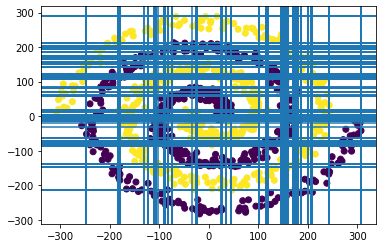

In [55]:
plt.scatter(X[0,:], X[1,:], c = Y)
for i in range(len(tree['index'])):
    if tree.iloc[i,2] == 0:
        plt.axvline(tree.iloc[i,3])
    else:
        plt.axhline(tree.iloc[i,3])
plt.show()

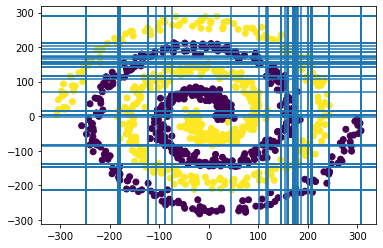

In [56]:
plt.scatter(X[0,:], X[1,:], c = Y)
for i in range(140):
    if tree.iloc[i,2] == 0:
        plt.axvline(tree.iloc[i,3])
    else:
        plt.axhline(tree.iloc[i,3])
plt.show()

In [57]:
tree.iloc[140,:]

index             738567.000000
treeLevel              7.000000
axisSplit              1.000000
thresholdVal         173.538231
leftNodeClass          1.000000
rightNodeClass         1.000000
Name: 140, dtype: float64

**Ric wrote:** I think that with a depth of 13 I can try to make the tree thresholds more manageable.

In [58]:
# These variables are global variables for unknown reason. Reset before running growTree()
# I know is a problem but I have no time to correct this issue.
thresholds = []
axes = []
levels = []
nodes = []
withinNodeProb = []

exEntropy = growTreeGetEntropy(spiralData,13)
print('Tree entropy with depth=13:',exEntropy)

Number of thresholds: 8191
Number of leaves: 44
Tree entropy with depth=13: 0.35731876472232116


In [59]:
treeData = pd.DataFrame(list(zip(levels,axes,thresholds,withinNodeProb)), 
                        columns =['treeLevel','axisSplit','thresholdVal','nodeProb']) 

treeData = treeData.dropna()

tree_Sorted = treeData.sort_values(by='treeLevel',ascending=False).reset_index(drop=False)
tree_Sorted['leftNodeClass'] = np.nan
tree_Sorted['rightNodeClass'] = np.nan

for i in range(len(tree_Sorted['index'])):
    if tree_Sorted.iloc[i,4][0][0] > tree_Sorted.iloc[i,4][0][1]:
        tree_Sorted.iloc[i,5] = 0
    else:
        tree_Sorted.iloc[i,5] = 1

    if tree_Sorted.iloc[i,4][1][0] > tree_Sorted.iloc[i,4][1][1]:
        tree_Sorted.iloc[i,6] = 0
    else:
        tree_Sorted.iloc[i,6] = 1

tree = tree_Sorted[['index','treeLevel','axisSplit','thresholdVal','leftNodeClass','rightNodeClass']]

In [60]:
tree.head(50)

,index,treeLevel,axisSplit,thresholdVal,leftNodeClass,rightNodeClass
0,0,13,1,211.488282,0.0,1.0
1,1,12,0,-247.108219,1.0,0.0
2,4096,12,0,146.650693,1.0,1.0
3,2,11,1,158.144253,1.0,1.0
4,4097,11,1,289.176756,1.0,1.0
5,2049,11,1,-213.383678,0.0,0.0
6,3,10,0,-247.108219,1.0,1.0
7,4098,10,0,146.650693,1.0,1.0
8,3073,10,0,-179.293142,0.0,1.0
9,2050,10,0,209.170000,0.0,1.0


In [61]:
tree.tail(5)

,index,treeLevel,axisSplit,thresholdVal,leftNodeClass,rightNodeClass
153,3702,1,1,153.586113,1.0,1.0
154,3709,1,1,113.717568,1.0,0.0
155,3712,1,1,152.211691,1.0,1.0
156,3720,1,1,4.402286,0.0,1.0
157,4107,1,1,289.176756,1.0,1.0


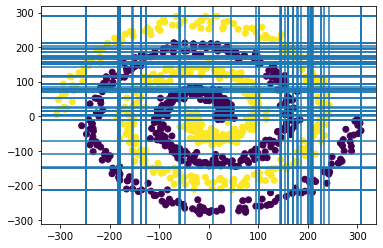

In [62]:
plt.scatter(X[0,:], X[1,:], c = Y)
for i in range(len(tree['index'])):
    if tree.iloc[i,2] == 0:
        plt.axvline(tree.iloc[i,3])
    else:
        plt.axhline(tree.iloc[i,3])
plt.show()

**Ric wrote:** As evidenced by the entropy and by the grid I printed on top of the plotted data, a depth of 13 would be enough to classify the points. Now I have to manage how to plot the regions.

In [63]:
treeData2 = pd.DataFrame(list(zip(levels,nodes,thresholds,withinNodeProb)), 
                        columns =['treeLevel','nodes','thresholdVal','nodeProb']) 

treeData2 = treeData2.dropna()

In [64]:
treeData2 = treeData2[treeData2['treeLevel']==1]
treeData2

treeData2['leftNodeClass'] = np.nan #col4
treeData2['rightNodeClass'] = np.nan #col5

for i in range(len(treeData2['treeLevel'])):
    if treeData2.iloc[i,3][0][0] > treeData2.iloc[i,3][0][1]:
        treeData2.iloc[i,4] = 0
    else:
        treeData2.iloc[i,4] = 1

    if treeData2.iloc[i,3][1][0] > treeData2.iloc[i,3][1][1]:
        treeData2.iloc[i,5] = 0
    else:
        treeData2.iloc[i,5] = 1

tree2 = treeData2[['treeLevel','nodes','thresholdVal','leftNodeClass','rightNodeClass']]
tree2

,treeLevel,nodes,thresholdVal,leftNodeClass,rightNodeClass
12,1,"[[[-307.21016377298884, -254.71687481934399, -...",158.144253,1.0,1.0
2059,1,"[[[-79.59395055792717, -87.19039307248627, -11...",-213.383678,0.0,1.0
3082,1,"[[[-218.61898544071227, -234.05154685746047, -...",116.793429,0.0,1.0
3209,1,"[[[-179.70473175146978, -181.23925380277328, -...",16.183116,0.0,1.0
3337,1,"[[[-238.1996843342906, -180.45440545919124, -2...",211.074105,1.0,1.0
3593,1,"[[[-154.212263359348, -163.98755960703394, -16...",52.601162,1.0,1.0
3594,1,"[[[-153.94643933326557, -154.00346089411448], ...",25.483209,1.0,1.0
3600,1,"[[[-128.41675395332564, -147.61953500277627, -...",79.707084,1.0,1.0
3624,1,"[[[-112.45269856436694, -60.217782398828135, -...",-150.205910,1.0,1.0
3627,1,"[[[-109.99115241111468, -109.54898648187881, -...",-0.883570,0.0,1.0


In [65]:
# Next step is to unpack the nodes
unpackedNodes = []
unpackaedLikelyClassNode = []
for i in range(len(tree2['treeLevel'])):
    for j in range(len(tree2.iloc[i,1])):
        unpackedNodes.append(tree2.iloc[i,1][j])
        unpackaedLikelyClassNode.append(tree2.iloc[i,(3+j)])

In [66]:
tree2v2 = pd.DataFrame(list(zip(unpackedNodes,unpackaedLikelyClassNode)), 
                        columns =['nodes','nodeProbClass'])
tree2v2

,nodes,nodeProbClass
0,"[[-307.21016377298884, -254.71687481934399, -2...",1.0
1,"[[nan], [nan], [nan]]",1.0
2,"[[-79.59395055792717, -87.19039307248627, -116...",0.0
3,"[[nan], [nan], [nan]]",1.0
4,"[[-218.61898544071227, -234.05154685746047, -2...",0.0
...,...,...
65,"[[-14.262653867399669, -84.23285536249355, -5....",0.0
66,"[[-66.0917140354373, 8.153507256632984, 17.250...",0.0
67,"[[nan], [nan], [nan]]",1.0
68,"[[-61.30207709548929, -15.756170078851117, -16...",1.0


In [67]:
nullNodes = []
for i in range(len(tree2v2)):
    if np.isnan(tree2v2.iloc[i,0]).all():
        nullNodes.append(i)

In [68]:
tree2v2 = tree2v2.drop(nullNodes)
tree2v3 = tree2v2.sort_values(by='nodeProbClass')
tree2v3

,nodes,nodeProbClass
21,"[[8.537963234831961, 72.13467384512631, 77.582...",0.0
33,"[[-16.470736957481428, -101.61357780833356, -2...",0.0
50,"[[299.6015249311597, 271.49123434585573, 261.3...",0.0
30,"[[27.78060103306693, -25.28408067521277, -33.5...",0.0
28,"[[-74.64796201613538, -53.122588991316114, -48...",0.0
52,"[[105.2113766783844, 93.79853543406078, 94.807...",0.0
26,"[[156.8095825794159, 167.1212672119213, 220.86...",0.0
54,"[[91.30777580110937, -130.8321545745354, 62.81...",0.0
40,"[[-149.3966505652604, -157.98725345061234, -15...",0.0
22,"[[202.9133011515193, 238.32098240678994, 242.4...",0.0


In [69]:
from tqdm import tqdm

In [70]:
# To create a mesh of coordinates
resolution = 5
x_min, x_max = -350, 350
y_min, y_max = -350, 350
xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

In [71]:
h = 0*xx

In [72]:
for i in tqdm(range(len(xx[0,:]))):
    for j in range(len(yy[:,0])):
        currCoord = np.array([xx[0,i],yy[j,0]])
        dist = 10000000000000
        for l in range(len(tree2v3.iloc[:,0])):
            for t in range(len(tree2v3.iloc[l,0][0,:])):
                coordInNode = tree2v3.iloc[l,0][:2,t]
                currDist = np.sqrt(np.power((coordInNode[0]-currCoord[0]),2)+np.power((coordInNode[1]-currCoord[1]),2))
                if currDist < dist:
                    dist = currDist
                    classLabel = tree2v3.iloc[l,1]
        h[i,j] = classLabel

100%|██████████| 140/140 [15:12<00:00,  6.52s/it]


**Ric wrote:** The following is the best I can do, this is just a tree. I cheated to make this tree classification, which has very poor performance. I was able only to grow a tree. I was able to get part of the structure of the tree. However, because of the missing values and errors its was tricky to figure out the splits. Thereby, I cheated by classifying the space by measuring the distance of every coordinate to the coordinates inside the leaves, then I labeled them as the moat probable class within the leaf node. 

The code was awfully slow, that is why I was able tu use a precision of only 5.

Probably if I would have been able to figure out the tree I would be able to figure out the bagging with the bootstrapped data datasets.

But since I was not able to figure out the right structure from the beginning I ran out of time. Tomorrow I promissed my kids to go hike with them. So, this is as far as I can go. Sorry!!!!!

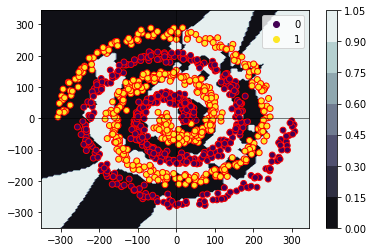

In [73]:
cs= plt.contourf(xx[0,:],yy[:,0],h,cmap ="bone")
cbar = plt.colorbar(cs)

lbl_names = [0,1]
scatter =plt.scatter(X[0,:], X[1,:], c = Y,edgecolors='r')

plt.axhline(0, color='black',lw=0.5)
plt.axvline(0, color='black',lw=0.5)

plt.legend(handles=scatter.legend_elements()[0],
           labels=lbl_names)
plt.show()

In [155]:
line1_x = [-350,thresh]
line1_y = [t[1],t[1]]
line2_x = [thresh,350]
line2_y = [t[6],t[6]]

line3_x = [t[7],t[7]]
line3_y = [-310,t[6]]
line4_x = [t[19],t[19]]
line4_y = [-310,t[6]]

line5_x = [-350,350]
line5_y = [t[3],t[3]]
#line6_x = 
#line6_y = [t[8],t[8]]
#line7_x = 
#line7_y = [t[13],t[13]]
#line8_x = 
#line8_y = [t[20],t[20]]

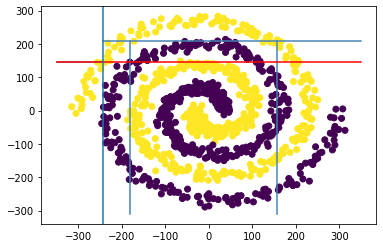

In [156]:
plt.scatter(X[0,:], X[1,:], c = Y)
plt.plot(line1_x,line1_y,'k-',c='steelblue')
plt.plot(line2_x,line2_y,'k-',c='steelblue')
plt.plot(line3_x,line3_y,'k-',c='steelblue')
plt.plot(line4_x,line4_y,'k-',c='steelblue')

plt.plot(line5_x,line5_y,'k-',c='red')
#plt.plot(line6_x,line6_y,'k-',c='steelblue')
#plt.plot(line7_x,line7_y,'k-',c='steelblue')
#plt.plot(line8_x,line8_y,'k-',c='steelblue')
plt.axvline(t[0])
plt.show()

In [74]:
def createLeaves(Matrix,threshold,axis):
    """Assumes a 2-d matrix and, a numpy array;
    a threshold value, a float
    and an axis value, axis=0 implies x-axis and axis=1 implies y-axis.
    Returns two matrices, a numpy array.
    One is matrix includes the subset of observations less or equal than the threshold,
    The second matrix includes the subset of observations greater than the threshold."""
    
    D_left = np.array([np.nan,np.nan]).reshape(2,1)
    D_right = np.array([np.nan,np.nan]).reshape(2,1)

    if axis not in (0,1):
        raise ValueError('Type 0 to search in x-axis or type 1 to search in y-axis')
 
    elif axis == 0:
        #print('0 branch')
        for i in range(len(Matrix[0,:])):
            if Matrix[:,i][0] <= threshold:
                currObservation = X[:,i].reshape(2,1)
                D_left = np.hstack((D_left,currObservation))
            elif Matrix[:,i][0] > threshold:
                currObservation = X[:,i].reshape(2,1)
                D_right = np.hstack((D_right,currObservation))
            else:
                print("Error in observation {}".format(i))
        
        if np.isnan(D_left).all():
            return D_left,D_right[:,1:]
        elif np.isnan(D_right).all():
            return D_left[:,1:],D_right
        else:
            return D_left[:,1:],D_right[:,1:]

    elif axis == 1:
        #print('1 branch')
        for i in range(len(Matrix[1,:])):
            if Matrix[:,i][1] <= threshold:
                currObservation = X[:,i].reshape(2,1)
                D_left = np.hstack((D_left,currObservation))
            elif Matrix[:,i][1] > threshold:
                currObservation = X[:,i].reshape(2,1)
                D_right = np.hstack((D_right,currObservation))
            else:
                print("Error in observation {}".format(i))
        
        if np.isnan(D_left).all():
            return D_left,D_right[:,1:]
        elif np.isnan(D_right).all():
            return D_left[:,1:],D_right
        else:
            return D_left[:,1:],D_right[:,1:]